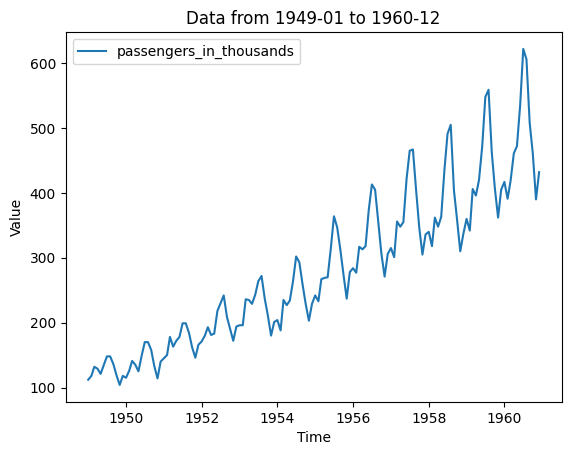

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

In [1]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline'
t = 16
h = 4

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, h=h, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, h=h, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, h=h, scaler=scaler)

modelPath = 'out/LSTMForecaster_airline/n1_hs128_h4_t16/best.pth.tar'
model = LSTMForecaster(input_size=len(input_field), output_size=len(output_field)*h, hidden_size=128, num_layers=1)
model.to(device)

load_checkpoint(modelPath, model)

criterion = torch.nn.L1Loss()

inference(test_dataset, model, criterion, device=device, batch_size=8)

=> loaded checkpoint 'True' (epoch 731)
Checkpoint's train loss is: 0.2228
Checkpoint's validation loss is: 0.0581


0.5341048240661621

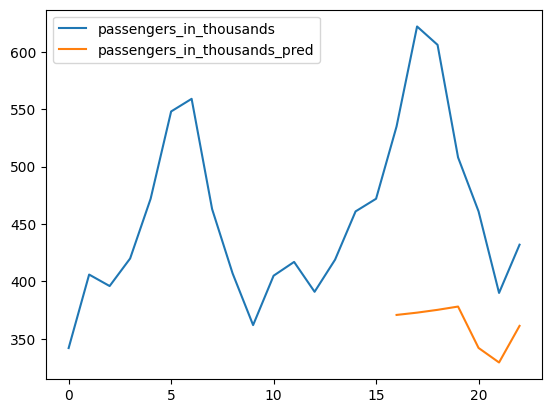

In [2]:
test_dataset.predict(model)
test_dataset.plot_forecast_result()

In [25]:
import pandas as pd
from pmdarima import auto_arima

data = pd.read_csv('data/airline/airline.csv')

output_field = ['passengers_in_thousands']

train_data = data[field].iloc[:-24]
test_data = data[field].iloc[-24:]

model = auto_arima(train_data, seasonal=True, m=12)
model.fit(train_data)

col_pred = [col + '_pred' for col in output_field]
train_data[col_pred] = model.predict()

120    345.739350
121    326.334142
122    372.828950
123    360.923494
124    377.731028
125    451.281825
126    508.613978
127    523.758020
128    423.740566
129    379.584404
130    331.309117
131    358.931523
132    368.205413
133    349.259284
134    396.148362
135    384.581518
136    401.679861
137    475.480414
138    533.027065
139    548.355323
140    448.496080
141    404.475795
142    356.317203
143    384.039829
dtype: float64

In [28]:
test_data

,passengers_in_thousands
120,360
121,342
122,406
123,396
124,420
125,472
126,548
127,559
128,463
129,407
